# DATA20001 Deep Learning - Group Project
## Image project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to a set of images.  The images are originally from a photo-sharing site and released under Creative Commons-licenses allowing sharing.  The training set contains 20 000 images. We have resized them and cropped them to 128x128 to make the task a bit more manageable.

We're only giving you the code for downloading the data. The rest you'll have to do yourselves.

Some comments and hints particular to the image project:

- One image may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are images that don't belong to any of our classes, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.

- As the dataset is pretty imbalanced, don't focus too strictly on the outputs being probabilistic. (Meaning that the right threshold for selecting the label might not be 0.5.)

- Image files can be loaded as numpy matrices for example using `imread` from `matplotlib.pyplot`. Most images are color, but a few grayscale. You need to handle the grayscale ones somehow as they would have a different number of color channels (depth) than the color ones.

- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Download the data

In [1]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
import zipfile

train_path = 'train'
dl_file = 'dl2018-image-proj.zip'
dl_url = 'https://users.aalto.fi/mvsjober/misc/'

zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

The above command downloaded and extracted the data files into the `train` subdirectory.

The images can be found in `train/images`, and are named as `im1.jpg`, `im2.jpg` and so on until `im20000.jpg`.

The class labels, or annotations, can be found in `train/annotations` as `CLASSNAME.txt`, where CLASSNAME is one of the fourteen classes: *baby, bird, car, clouds, dog, female, flower, male, night, people, portrait, river, sea,* and *tree*.

Each annotation file is a simple text file that lists the images that depict that class, one per line. The images are listed with their number, not the full filename. For example `5969` refers to the image `im5969.jpg`.

## Your stuff goes here ...

# Preprocess and preparing Dataloader

First we format the labels to usable form. Saved as csv to `./train/labels.csv`

In [75]:
import pandas as pd
import glob
from sklearn.preprocessing import OneHotEncoder

# Create an array with tuple(img, label) pairs from the annotations txt files.
files = glob.glob("./train/annotations/*")
labels = []
for name in files:
    try:
        with open(name) as f:
            label = name.split("\\")[1].split(".")[0]
            for line in f:
                labels.append((int(line.splitlines()[0]), label))

    except IOError as exc: #Not sure what error this is
        if exc.errno != errno.EISDIR:
            raise
            
# Create dataframe with columns img, label and sort it by img and reset index without preserving old index values.
labels = pd.DataFrame(labels, columns=["img", "label"])
# One hot encoding
one_hot = pd.get_dummies(labels["label"])
labels = labels.join(one_hot).drop("label", axis="columns")
labels = labels.groupby("img", as_index=False).sum()
labels["img"] = labels["img"].astype("int32")
imgs_present = labels["img"].unique()
rows_to_add = []
for i in range(20000 - 1): # this takes a while sry
    if i+1 in imgs_present:
        continue
    else:
        rows_to_add.append([i+1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # kinda ugly lol
df_to_append = pd.DataFrame(rows_to_add, columns=["img","baby", "bird",
                                                  "car", "clouds", "dog",
                                                  "female", "flower",
                                                  "male","night", "people",
                                                  "portrait", "river", "sea",
                                                  "tree"])

labels = labels.append(df_to_append).sort_values("img").reset_index(drop=True)
print(labels)
labels.to_csv("./train/labels.csv")

         img  baby  bird  car  clouds  dog  female  flower  male  night  \
0          1     0     0    0       0    0       1       0     0      0   
1          2     0     0    0       0    0       0       0     0      0   
2          3     0     0    0       0    0       0       0     0      0   
3          4     0     0    0       0    0       0       0     1      0   
4          5     0     0    0       0    0       0       0     1      0   
5          6     0     0    0       0    0       0       0     0      0   
6          7     0     0    0       0    0       1       0     0      0   
7          8     0     0    0       0    0       0       0     0      0   
8          9     0     0    0       0    0       0       0     0      0   
9         10     0     0    0       0    0       0       0     0      0   
10        11     0     0    0       0    0       0       0     1      0   
11        12     0     0    0       0    0       1       0     0      0   
12        13     0     0 

10176 rows with any labels and 9824 images without a label.

## Dataset and Dataloader
We create our Dataset to be used through Dataloader to train and evaluate our model

In [83]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import imageio
import multiprocessing
import numpy as np
import torch

class Images(Dataset):
    def __init__(self): 
        """
        Initialize dataset.
        Here we can define transformations for the dataset aswell.
        """        
        self.labels = pd.read_csv("./train/labels.csv")
        self.center_crop = transforms.CenterCrop(100)
        self.to_tensor = transforms.ToTensor()
        
        self.transformations = transforms.Compose([transforms.CenterCrop(100), transforms.ToTensor()])
        
    def __getitem__(self, index):
        index = index.item() + 1 #indexing starts from 1 in our dataset
        try:
            img = np.array(imageio.imread('./train/images/im' + str(index) + '.jpg', pilmode="RGB"))
        except:
            raise
        
        img = self.to_tensor(img)
       # e.g. data = self.center_crop(data)
        label = labels[labels["img"] == index].drop("img", axis="columns")
        label = torch.from_numpy(np.array(label))
        return (img, label.squeeze())

    def __len__(self):
        return len(self.labels)
imgs = Images()

train_size = int(0.8 * len(imgs))
test_size = len(imgs) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(imgs, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(dataset=validation_dataset, batch_size=32, shuffle=False)


#### We can now use our `train_loader` as such:

In [84]:
for idx, (X, y) in enumerate(train_loader):
    if idx == 5:
        print("and so on...")
        break
    print ("batch", idx, "img", X.shape,"label", y.shape)

batch 0 img torch.Size([32, 3, 128, 128]) label torch.Size([32, 14])
batch 1 img torch.Size([32, 3, 128, 128]) label torch.Size([32, 14])
batch 2 img torch.Size([32, 3, 128, 128]) label torch.Size([32, 14])
batch 3 img torch.Size([32, 3, 128, 128]) label torch.Size([32, 14])
batch 4 img torch.Size([32, 3, 128, 128]) label torch.Size([32, 14])
and so on...


In [85]:
def y_to_labels(y):
    """
    a little helper function to get labels from one-hot-encoded vectors
    """
    labels = pd.read_csv("./train/labels.csv").drop(["Unnamed: 0","img"], axis="columns").columns
    return list(labels.take(np.where(np.array(y))).ravel())

#### lets see few examples from the dataset

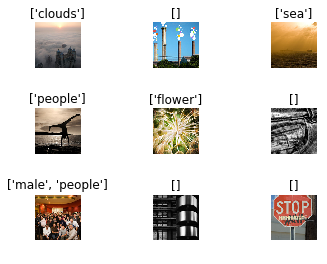

In [87]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(3,3)
f.subplots_adjust(hspace=0.9)

for i, ax in enumerate(f.axes):
    X, y = imgs.__getitem__(torch.tensor(i+999))
    ax.axis('off')
    ax.imshow(np.array(X.permute(1,2,0)))
    ax.set_title(str(y_to_labels(y)))

In [92]:
import torch
from torchtext import datasets, vocab

import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
    print('Using gpu.')
    device = torch.device('cuda')
else:
    print('Using CPU.')
    device = torch.device('cpu')
    
class Net(nn.Module):
    def __init__(self, output_size = 14, batch_size=32):
        super(Net, self).__init__()
        self.output_size = output_size
        self.batch_size = batch_size
        self.fc = nn.Linear(128*128*3, output_size)
        
    def forward(self, x):
       #x = [batch_size, color_dim, x, y]
        x = x.view(-1, 128*128*3)
        output = self.fc(x)
        return output

model = Net().to(device) 
optimizer = torch.optim.Adam(model.parameters())
# I think Binary Cross Entropy is OK for multilabel. LogitsLoss is just added sigmoid with log-sum-exp trick
criterion = nn.BCEWithLogitsLoss().to(device)

print(model)

Using gpu.
Net(
  (fc): Linear(in_features=49152, out_features=14, bias=True)
)


In [99]:
def train(model, loader, optimizer, criterion):
    
    epoch_loss = 0
    
    model.train()
    
    for idx, (X, y) in enumerate(loader):
        X = X.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        
        predictions = model(X)
        
        loss = criterion(predictions, y.float())
                
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

In [102]:
from sklearn.metrics import f1_score

def evaluate(model, loader, criterion):
    
    epoch_loss = 0
    epoch_f1 = 0
    
    model.eval() # disables normalizations like dropout, batchnorm etc..
    
    with torch.no_grad(): # disables autograd engine
    
         for idx, (X, y) in enumerate(loader):
            X = X.to(device)
            y = y.to(device)
            
            predictions = model(X)
            
            loss = criterion(predictions, y.float())
            # just round for label true/false
            rounded_preds = torch.round(torch.sigmoid(predictions)) # also sigmoid because its not used without loss function
            
            # micro-averaged f1 is used for determining the best model.
            f1 = f1_score(rounded_preds, y, average='micro')

            epoch_loss += loss.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(loader), epoch_f1 / len(loader)

In [106]:
N_EPOCHS = 1

for epoch in range(N_EPOCHS):
    print(f"started training epoch {epoch + 1}..")
    train_loss = train(model, train_loader, optimizer, criterion)
    print(f"started validating epoch {epoch + 1}..")
    valid_loss, valid_f1 = evaluate(model, valid_loader, criterion)
    print(f'Training epoch {epoch +1},  loss: {train_loss}')
    print(f'Validation epoch {epoch +1}: loss: {valid_loss}, F1 score: {valid_f1}')

started training epoch 1..
started validating epoch 1..
Training epoch 1,  loss: 0.38252091681957245
Validation epoch 1: loss: 0.5250547001361847, F1 score: 0.06241207850154949


## Save your model

It might be useful to save your model if you want to continue your work later, or use it for inference later.

In [ ]:
torch.save(model.state_dict(), 'model.pkl')

The model file should now be visible in the "Home" screen of the jupyter notebooks interface.  There you should be able to select it and press "download".  [See more here on how to load the model back](https://github.com/pytorch/pytorch/blob/761d6799beb3afa03657a71776412a2171ee7533/docs/source/notes/serialization.rst) if you want to continue training later.

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

## Predict for test set

You should return your predictions for the test set in a plain text file.  The text file contains one row for each test set image.  Each row contains a binary prediction for each label (separated by a single space), 1 if it's present in the image, and 0 if not. The order of the labels is as follows (alphabetic order of the label names):

    baby bird car clouds dog female flower male night people portrait river sea tree

An example row could like like this if your system predicts the presense of a bird and clouds:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0
    
The order of the rows should be according to the numeric order of the image numbers.  In the test set, this means that the first row refers to image `im20001.jpg`, the second to `im20002.jpg`, and so on.

If you have the prediction output matrix prepared in `y` you can use the following function to save it to a text file.

In [ ]:
np.savetxt('results.txt', y, fmt='%d')